In [64]:
!pip install GitPython
import os
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import (accuracy_score, classification_report, confusion_matrix)
from sklearn.preprocessing import LabelEncoder
import joblib
from scipy.stats import randint



import pandas as pd 
import os 
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, classification_report,confusion_matrix
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import GridSearchCV
from sklearn import tree
from sklearn.model_selection import cross_val_score

import seaborn as sns
from sklearn.preprocessing import LabelEncoder
import joblib



In [66]:
file_path = 'C:/Users/ChazinBrahma/Downloads/archive (25)/loan_default.csv'
lending_df = pd.read_csv(file_path)

if os.path.exists(file_path):
    print("File path is correct.")
else: 
    print("File path is incorrect.")

File path is correct.


In [67]:
lending_df.dropna(axis=0, how='any', inplace=True)
lending_df.drop_duplicates(inplace=True)            

y = lending_df['Default']
X = lending_df.drop('Default', axis=1)

if 'LoanID' in X.columns:
    X.drop('LoanID', axis=1, inplace=True)

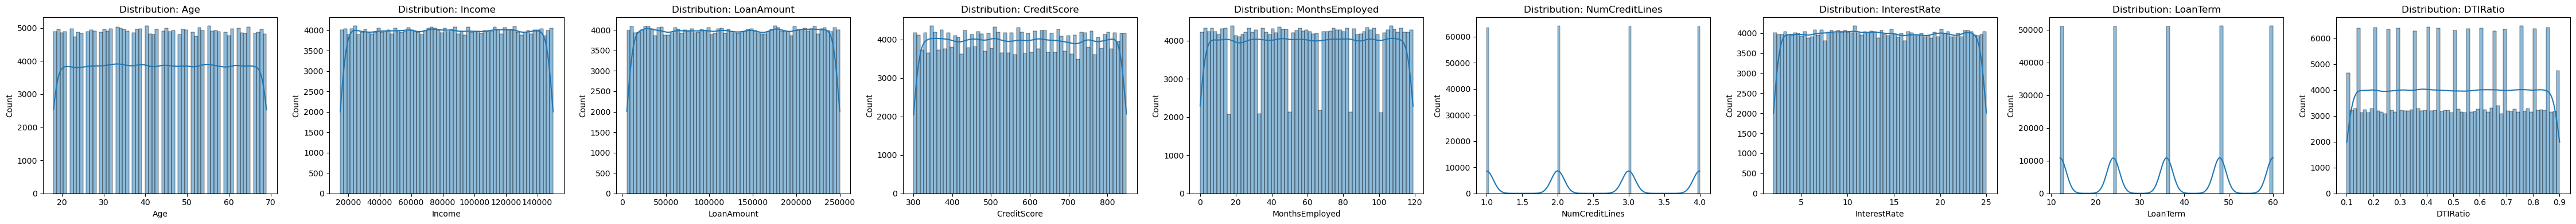

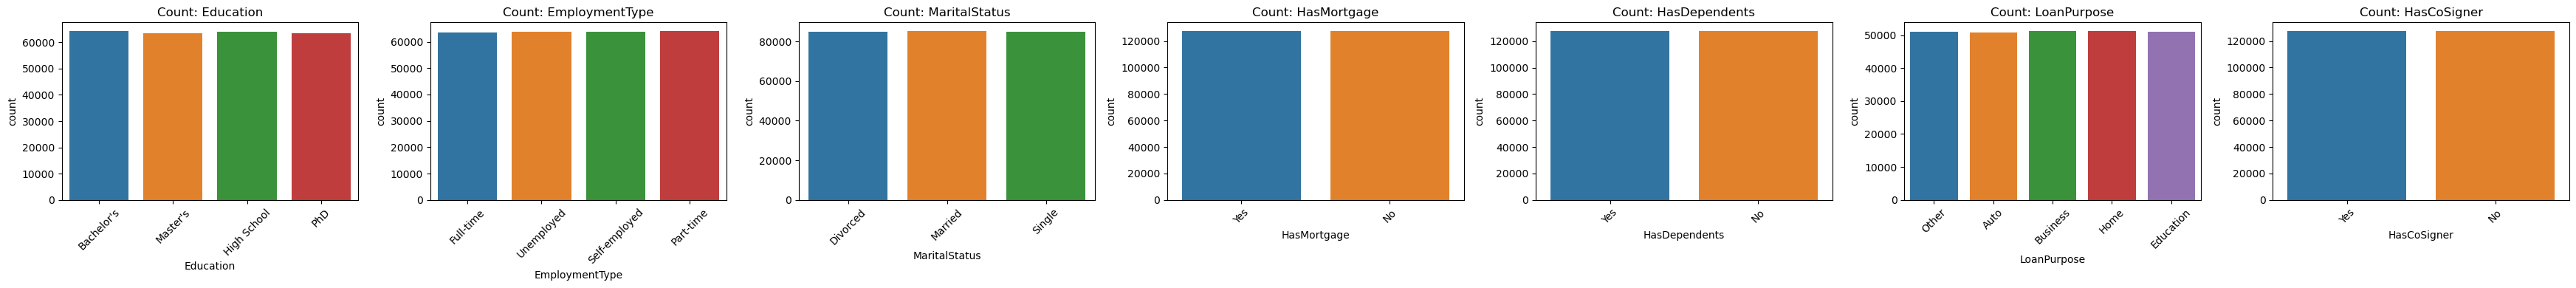

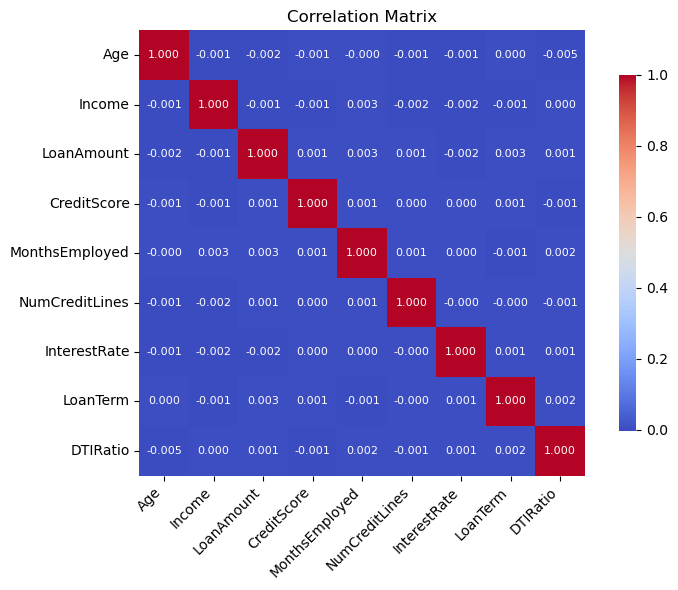

In [68]:
plots_dir = "plots_new"
os.makedirs(plots_dir, exist_ok=True)

cat_cols = [col for col in X.columns if X[col].dtype == 'object']
num_cols = [col for col in X.columns if X[col].dtype in ['int64', 'float64']]


if len(num_cols) > 0:
    fig, axes = plt.subplots(nrows=1, ncols=len(num_cols), figsize=(5 * len(num_cols), 4))
    if len(num_cols) == 1:
        axes = [axes]  
    for i, col in enumerate(num_cols):
        sns.histplot(lending_df[col], kde=True, ax=axes[i])
        axes[i].set_title(f"Distribution: {col}")
    plt.tight_layout()
    plt.savefig(os.path.join(plots_dir, "numeric_distribution.png"), dpi=300)
    plt.show()


if len(cat_cols) > 0:
    fig, axes = plt.subplots(nrows=1, ncols=len(cat_cols), figsize=(5 * len(cat_cols), 4))
    if len(cat_cols) == 1:
        axes = [axes]
    for i, col in enumerate(cat_cols):
        sns.countplot(x=col, data=lending_df, ax=axes[i])
        axes[i].tick_params(axis='x', rotation=45)
        axes[i].set_title(f"Count: {col}")
    plt.tight_layout()
    plt.savefig(os.path.join(plots_dir, "categorical_distribution.png"), dpi=300)
    plt.show()


if len(num_cols) > 1:
    corr_matrix = lending_df[num_cols].corr()
    plt.figure(figsize=(8,6))  
    heatmap = sns.heatmap(
        corr_matrix,
        annot=True,
        fmt=".3f",  
        cmap='coolwarm',
        square=True,
        cbar_kws={"shrink": 0.8},
        annot_kws={"size": 8}  
    )
    plt.xticks(rotation=45, ha='right')
    plt.yticks(rotation=0)
    plt.title("Correlation Matrix")
    plt.tight_layout()
    plt.savefig(os.path.join(plots_dir, "correlation_matrix.png"), dpi=300)
    plt.show()

In [69]:
label_encoder = LabelEncoder()
for col in cat_cols:
    X[col] = label_encoder.fit_transform(X[col])

In [70]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

In [71]:
param_dist = {
    "max_depth": [3, 5, 10, None],
    "min_samples_split": randint(2, 10),
    "min_samples_leaf": randint(1, 5),
    "criterion": ["gini", "entropy"]
}

dt = DecisionTreeClassifier(random_state=42)

random_search = RandomizedSearchCV(
    estimator=dt,
    param_distributions=param_dist,
    n_iter=10,             # even fewer combos for speed
    cv=3,                  # reduce folds
    n_jobs=-1,            # parallel
    random_state=42,
    verbose=1
)
random_search.fit(X_train, y_train)

print("\nBest hyperparameters:", random_search.best_params_)

best_model = random_search.best_estimator_


Fitting 3 folds for each of 10 candidates, totalling 30 fits

Best hyperparameters: {'criterion': 'entropy', 'max_depth': 5, 'min_samples_leaf': 2, 'min_samples_split': 3}



Accuracy on Test: 0.89
Classification Report:
               precision    recall  f1-score   support

           0       0.89      1.00      0.94     45170
           1       0.61      0.02      0.05      5900

    accuracy                           0.89     51070
   macro avg       0.75      0.51      0.49     51070
weighted avg       0.85      0.89      0.84     51070



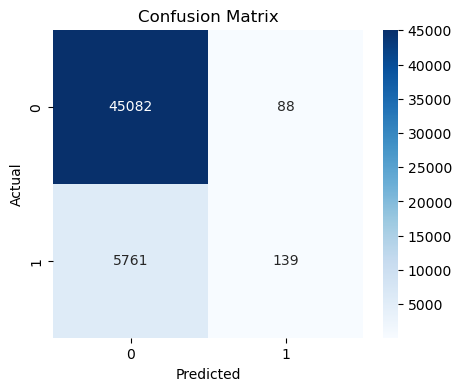

In [72]:
y_pred = best_model.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print(f"\nAccuracy on Test: {accuracy:.2f}")
print("Classification Report:\n", classification_report(y_test, y_pred))

conf_matrix = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(5,4))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix')
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.savefig(os.path.join(plots_dir, 'confusion_matrix.png'), dpi=300)
plt.show()

In [73]:
model_filename = "best_loan_default_model.pkl"
joblib.dump(best_model, model_filename)
print(f"Model saved to {model_filename}.")

Model saved to best_loan_default_model.pkl.


In [74]:
loaded_model = joblib.load(model_filename)
y_pred_loaded = loaded_model.predict(X_test)
acc_loaded = accuracy_score(y_test, y_pred_loaded)
print(f"Reloaded Model Accuracy: {acc_loaded:.2f}")

Reloaded Model Accuracy: 0.89
